In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=a2vvHeFgVtCp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


In [2]:
ticker = "AAPL"

In [15]:
from LSTMmodel import MultiLSTMModel, load_model

num_features = 5
input_size = num_features
OUT_STEPS = 16
lstm = MultiLSTMModel(input_size=input_size, lstm_units=32, out_steps=OUT_STEPS, num_features=num_features)
lstm = load_model(lstm, f"models/trained_lstm_{ticker}_epoch1500.pth")

In [3]:
from source.IB_connector import retrive_market_data

training_set_aapl = retrive_market_data([ticker], duration = "1 m", time_interval = "15 mins")
training_set = training_set_aapl[ticker]
training_set['Volume'] = training_set['Volume'].astype(float)
training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
col_select = ['Open','High','Low','Close','Volume']
training_set = training_set[col_select]
training_set.dtypes
CLOSE_INDEX = col_select.index('Close')

Found window with title: Login
Found window with title: DUK343627 Interactive Brokers (Simulated Trading)


ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


In [17]:
from enviroments import TimeSeriesEnvFuturePredict
#CLOSE_INDEX = 3
env = TimeSeriesEnvFuturePredict(data=training_set['Close'].values, lstm=lstm,lstm_data=training_set.values,device="cuda",
                                 train_std = training_set.std()[CLOSE_INDEX],train_mean= training_set.mean()[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

In [20]:
from rl_agent import load_dqn_agent, DQNAgent

agent = DQNAgent(observation_space=env.observation_space.shape[0], action_space=env.action_space.n)
#load_dqn_agent(agent, f"models/trained_agent_{ticker}_episode200.pth")
load_dqn_agent(agent, f"aapl_15min_norm_8env.pth")

Model załadowany z aapl_15min_norm_8env.pth


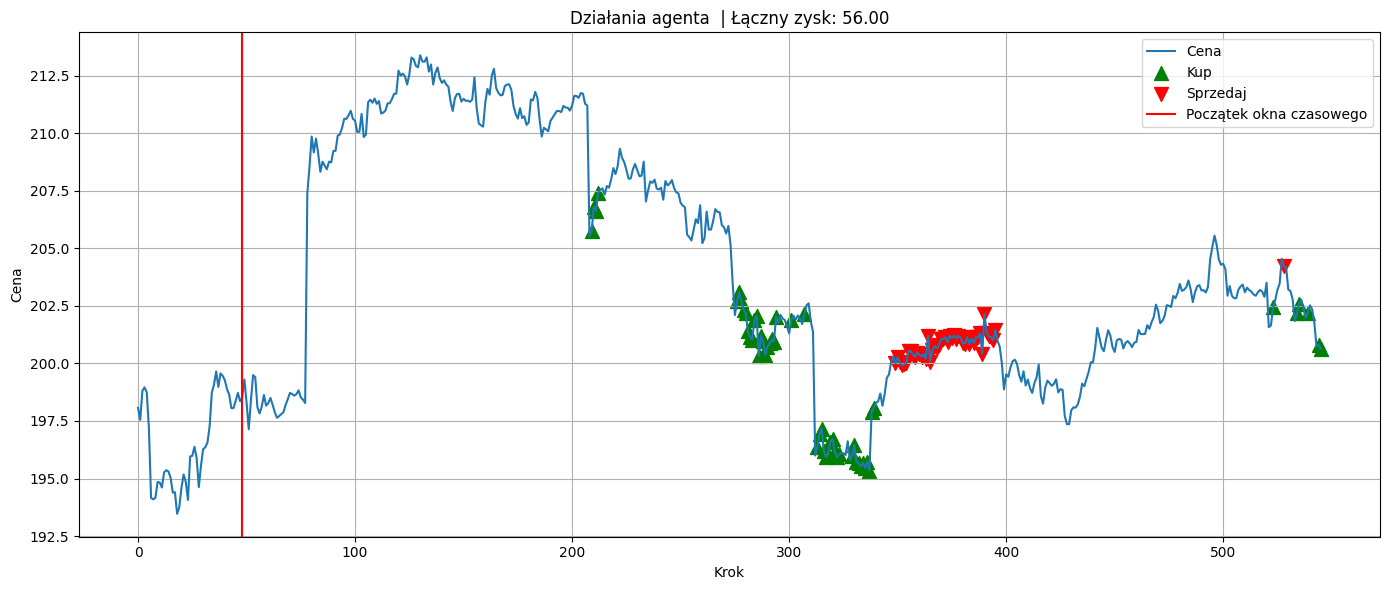

In [21]:
from eval_models import evaluate_steps, render_env

env.reset()
evaluate_steps(env, agent.target_model)
render_env(env, title_suffix="")